In [1]:
import tensorflow
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from osgeo import gdal
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,Dropout,Conv2DTranspose,concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import ReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [2]:
def raster2rgb(img_data):
	bands_count = img_data.RasterCount
	
	r = img_data.GetRasterBand(4)
	g = img_data.GetRasterBand(3)
	b = img_data.GetRasterBand(2)
	
	r1 = r.ReadAsArray()
	g1 = g.ReadAsArray()
	b1 = b.ReadAsArray()
	
	img = np.dstack((r1,g1,b1))
	
	out = np.zeros_like(img).astype(np.float32)
	n = img.shape[2]
	for i in range(n):
		a, b = 0, 1
		c = np.percentile(img[:,:,i],2)
		d = np.percentile(img[:,:,i],98)
		t = a +(img[:,:,i]-c)*(b-a)/(d-c)
		t[t<a] = a
		t[t>b] = b
		out[:,:,i] = t
		
	return out


In [3]:
def images_split(total_images_path):
    total_images = []
    for file in glob.iglob(total_images_path+'**/*.tif',recursive=True):
        image = gdal.Open(file, gdal.GA_ReadOnly)
        output_image = raster2rgb(image)
        total_images.append(output_image)
    
    total_images_count = len(total_images)
    total_images = np.asarray(total_images)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    X_train = []
    X_valid = []
    X_test = []

    for i in range(0,n_train):
        X_train.append(total_images[i])
	
    for i in range(n_train,n_train+n_valid):
        X_valid.append(total_images[i])
	
    for i in range(n_train+n_valid,len(total_images)):
        X_test.append(total_images[i])
    
    X_train = np.asarray(X_train)
    X_valid = np.asarray(X_valid)
    X_test = np.asarray(X_test)
	
    return X_train,X_valid,X_test
    

In [4]:
total_images_path= 'D:/vision_impulse/images/'
X_train, X_valid, X_test = images_split(total_images_path)

In [5]:
print(X_train.shape[0])
print(X_valid.shape[0])
print(X_test.shape[0])


4506
1100
80


In [6]:
def raster2label(img_data):
	bands_count = img_data.RasterCount
	if bands_count ==1:
		gray = img_data.GetRasterBand(1)
	
		gray1 = gray.ReadAsArray()
	
		label = np.asarray(gray1)
		
	return label


In [7]:
def labels_split(total_labels_path):
    total_labels = []
    for file in glob.iglob(total_labels_path+'**/*.tif',recursive=True):
        label = gdal.Open(file, gdal.GA_ReadOnly)
        output_label = raster2label(label)
        total_labels.append(output_label)
    
    total_label_count = len(total_labels)
    total_labels = np.asarray(total_labels)
    n_train = 4506
    n_valid = 1100
    n_test = 80
    y_train = []
    y_valid = []
    y_test = []

    for i in range(0,n_train):
        y_train.append(total_labels[i])
	
    for i in range(n_train,n_train+n_valid):
        y_valid.append(total_labels[i])
	
    for i in range(n_train+n_valid,len(total_labels)):
        y_test.append(total_labels[i])
    
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    y_test = np.asarray(y_test)
	
    return y_train,y_valid,y_test


In [8]:
total_labels_path = 'D:/vision_impulse/labels/'
y_train, y_valid, y_test = labels_split(total_labels_path)

In [9]:
assert X_train.shape[0] == y_train.shape[0]
print(f'X_train and y_train are of same length : {X_train.shape[0]}')

X_train and y_train are of same length : 4506


In [10]:
def visualize(viz_list):
    plt.figure(figsize=(15,15))
    title = ['Input_image', 'Input_mask', 'predicted_mask']
    
    for i in range(len(viz_list)):
        plt.subplot(1,len(viz_list), i+1)
        plt.title(title[i])
        plt.imshow(viz_list[i])
        plt.axis('off')
    plt.show()
    

4485


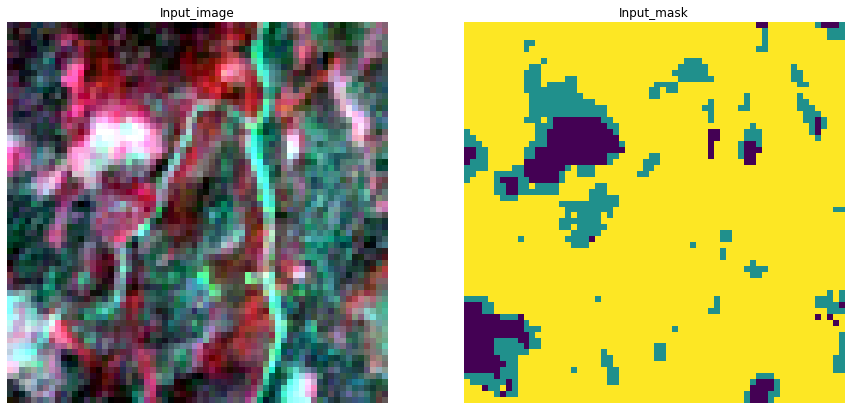

In [11]:
from random import randint
rand_num = randint(0,X_train.shape[0])
print(rand_num)

visualize([X_train[rand_num],y_train[rand_num]])

In [12]:
def conv_block(input_tensor, num_filters,kernel_size):
    c = Conv2D(filters= num_filters,kernel_size=kernel_size,kernel_initializer='he_normal',strides=(1,1),padding='same')(input_tensor)
    c = ReLU()(c)
    return c



In [13]:


def U_Net(input_lr,num_filters=64,kernel_size=3,dropout_rate=0.1):
    
    #block1
    c1 = conv_block(input_lr,num_filters*1,kernel_size=kernel_size)
    c2 = conv_block(c1,num_filters*1,kernel_size=kernel_size)
    p1 = MaxPooling2D(pool_size=(2,2))(c2)
    
    #block2
    c3 = conv_block(p1,num_filters*2,kernel_size=kernel_size)
    c4 = conv_block(c3,num_filters*2,kernel_size=kernel_size)
    p2 = MaxPooling2D(pool_size=(2,2))(c4)
    
    #block3
    c5 = conv_block(p2,num_filters*4,kernel_size=kernel_size)
    c5 = Dropout(dropout_rate)(c5)
    c6 = conv_block(c5,num_filters*4,kernel_size=kernel_size)
    p3 = MaxPooling2D(pool_size=(2,2))(c6)
    
    #block4
    c7 = conv_block(p3,num_filters*8,kernel_size=kernel_size)
    c7 = Dropout(dropout_rate)(c7)
    c8 = conv_block(c7,num_filters*8,kernel_size=kernel_size)
    p4 = MaxPooling2D(pool_size=(2,2))(c8)
    
    #block5(bottleneck)
    c9 = conv_block(p4,num_filters*16,kernel_size = kernel_size)
    c10 = conv_block(c9,num_filters*16,kernel_size=kernel_size)
    
    #expanding block (block6)
    u6 = Conv2DTranspose(filters=num_filters*8,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c10)
    u6 = concatenate([u6,c8])
    c11 = conv_block(u6,num_filters*8,kernel_size=kernel_size)
    c11 = Dropout(dropout_rate)(c11)
    c12 = conv_block(c11,num_filters*8,kernel_size=kernel_size)
    
    #block7
    u7 = Conv2DTranspose(filters=num_filters*4,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c12)
    u7 = concatenate([u7,c6])
    c13 = conv_block(u7,num_filters*4,kernel_size=kernel_size)
    c13 = Dropout(dropout_rate)(c13)
    c14 = conv_block(c13,num_filters*4,kernel_size=kernel_size)
    
    #block8
    u8 = Conv2DTranspose(filters=num_filters*2,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c14)
    u8 = concatenate([u8,c4])
    c15 = conv_block(u8,num_filters*2,kernel_size=kernel_size)
    c15 = Dropout(dropout_rate)(c15)
    c16 = conv_block(c15,num_filters*2,kernel_size=kernel_size)
    
    #block9
    u9 = Conv2DTranspose(filters= num_filters*1,kernel_size=(3,3),strides=(2,2),kernel_initializer='he_normal',padding='same')(c16)
    u9 = concatenate([u9,c2])
    c17 = conv_block(u9,num_filters*1,kernel_size=kernel_size)
    c18 = conv_block(c17,num_filters*1,kernel_size=kernel_size)
    
    output = Conv2D(filters=1,kernel_size=(1,1),strides=(1,1),padding='same',activation='sigmoid',kernel_initializer='he_normal')(c18)
    
    model = Model(inputs=[input_lr],outputs=[output])
    
    return model


In [14]:
input_lr = Input((X_train.shape[1],X_train.shape[2],X_train.shape[3]),name='input_lr')
model = U_Net(input_lr)
model.compile(optimizer=Adam(1e-4),loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_lr (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   1792        input_lr[0][0]                   
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       re_lu[0][0]                      
______________________________________________________________________________________________

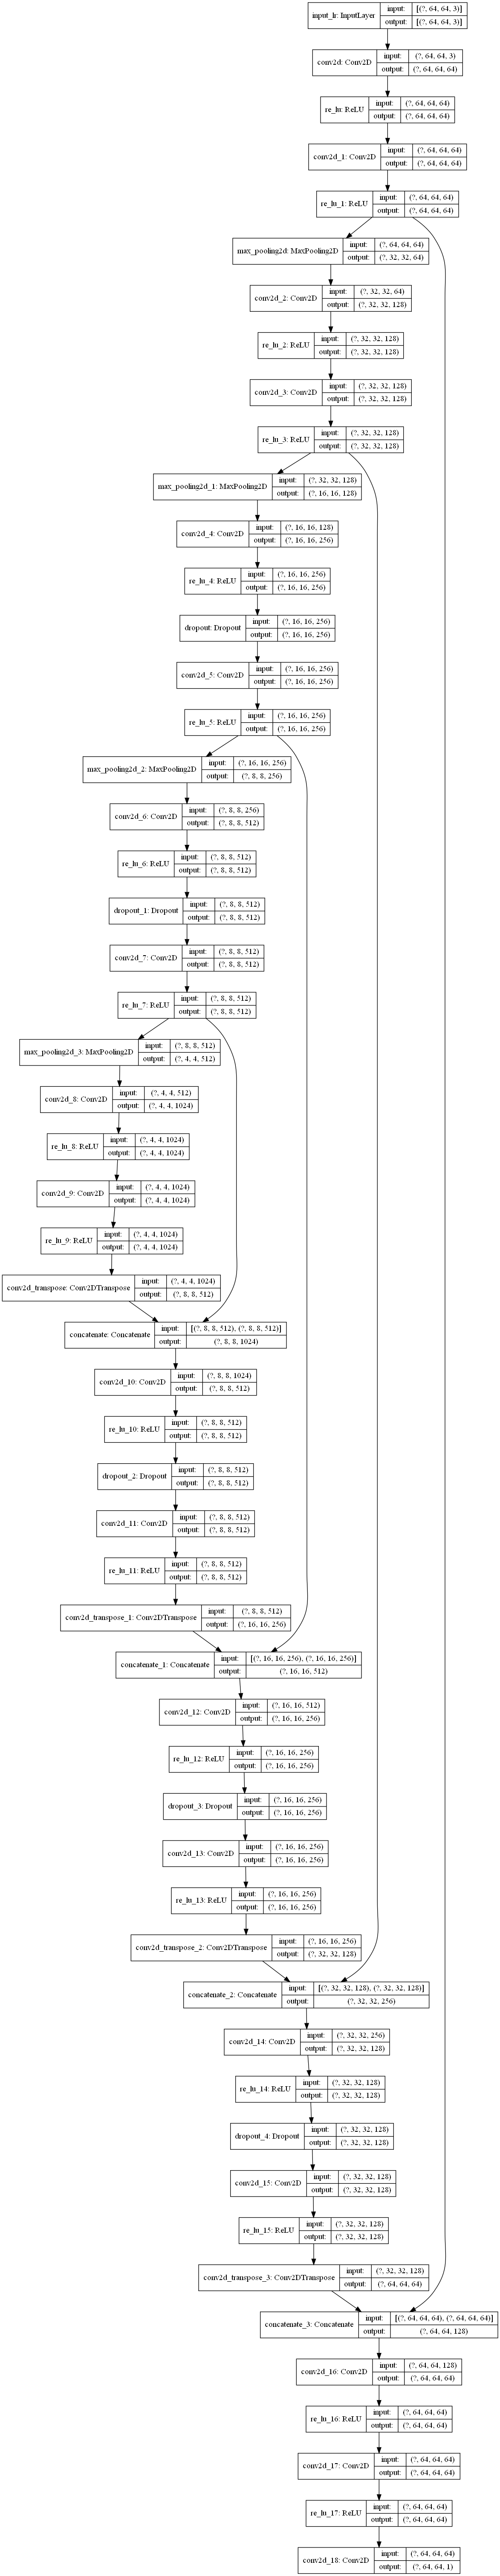

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [18]:
weights_path = 'D:/vision_impulse/weights/'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
    
file_path = os.path.join(weights_path+'model/')
print(file_path)

D:/vision_impulse/weights/model/


In [19]:
es = EarlyStopping(patience=5,monitor='val_loss',mode ='auto',restore_best_weights=True)
mc = ModelCheckpoint(filepath = file_path,monitor='val_loss',save_best_only=True)


In [20]:
batch_size = 16
steps_per_epoch = int(X_train.shape[0])//batch_size
epochs = 30

In [21]:
history = model.fit(X_train,y_train, epochs=epochs,steps_per_epoch= steps_per_epoch, validation_data =(X_valid, y_valid),callbacks = [es,mc] )


Epoch 1/30
281/281 [==============================] - ETA: 0s - loss: 0.1121 - accuracy: 0.6305WARNING:tensorflow:From C:\Users\Dheeraj Reddy P\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py:1817: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/vision_impulse/weights/model/assets
281/281 [==============================] - 39s 137ms/step - loss: 0.1121 - accuracy: 0.6305 - val_loss: -0.5694 - val_accuracy: 0.4902
Epoch 2/30
281/281 [==============================] - 34s 121ms/step - loss: -0.3355 - accuracy: 0.6584 - val_loss: -1.0385 - val_accuracy: 0.5873
Epoch 3/30
281/281 [==============================] - 34s 121ms/step - loss: -0.6019 - accuracy: 0.6789 - val_loss: -1.1774 - val_accuracy: 0.5464
Epoch 4/30
281/

In [22]:
model.save('D:/vision_impulse/weights/mymodel.h5')

In [24]:
y_pred =model.predict(X_test)

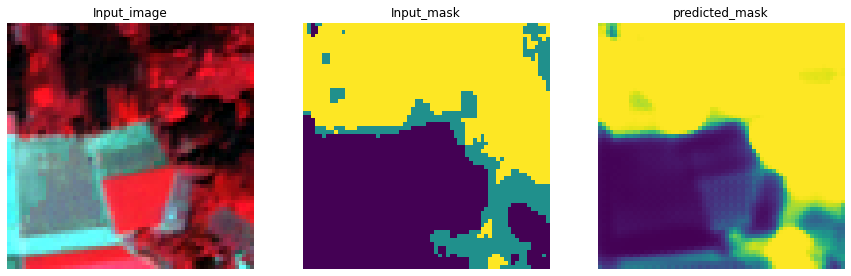

In [31]:
visualize([X_test[0],y_test[0],y_pred[0]])

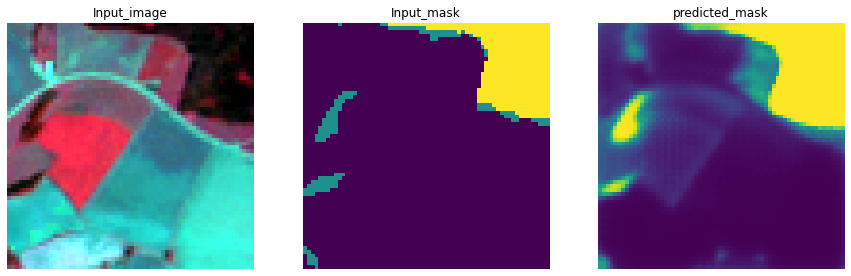

In [34]:
visualize([X_test[15],y_test[15],y_pred[15]])

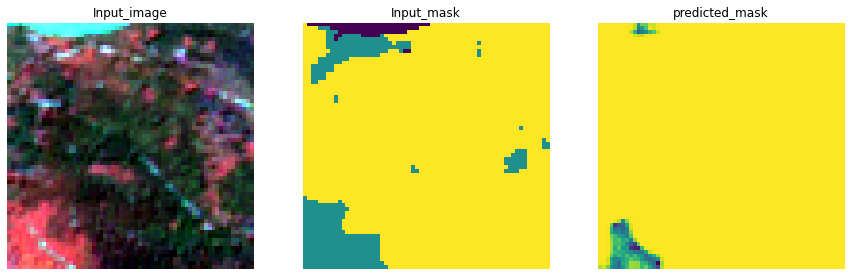

In [38]:
visualize([X_test[46],y_test[46],y_pred[46]])